## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
import glob
import math
from PIL import Image

import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

from efficientnet_pytorch import EfficientNet

In [7]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

## 1. Model 정의

In [3]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
model = EfficientNet.from_pretrained('efficientnet-b4')
model._fc = torch.nn.Linear(in_features=1792, out_features=18, bias=True)
model.load_state_dict(torch.load('/opt/ml/input/data/train/model/08-26-01.pth'))
model

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

## 2. Test Dataset 정의

In [4]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    transforms.CenterCrop(380),
    # Resize((380, 380), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
# model = MyModel(num_classes=18).to(device)
model = model.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [9]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


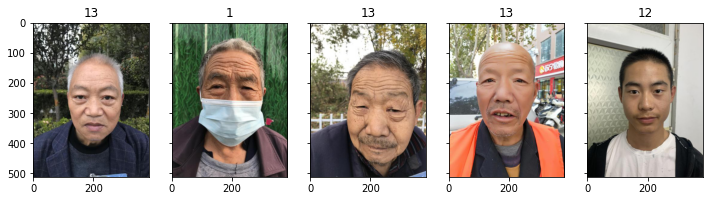

In [25]:
import matplotlib.pyplot as plt
imgs = submission['ImageID']
label = submission['ans']
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12, 6))
for i, j in enumerate(range(5)):
    axes[i].imshow(Image.open('/opt/ml/input/data/eval/images/' + imgs[j]))
    axes[i].set_title(f'{label[j]}')
plt.show()